# Desafio - Módulo 4

## Atividades (Enunciado)

Fonte: https://www.tensorflow.org/hub/tutorials/tf2_image_retraining?hl=pt

### Configuração

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
AUTOTUNE

-1

In [ ]:
import itertools
import os

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

In [ ]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


### Selecione o módulo TF2 SavedModel para usar

In [ ]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


### Configure o conjunto de dados do Flowers (explorar os dados)

In [ ]:
import pathlib

data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['dandelion', 'roses', 'tulips', 'sunflowers', 'daisy'],
      dtype='<U10')

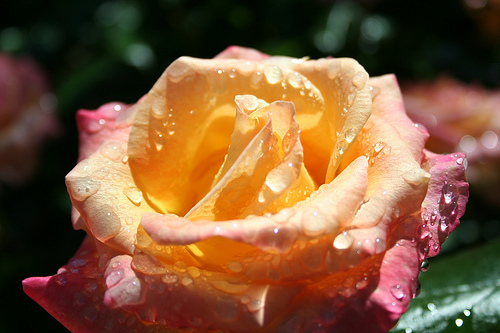

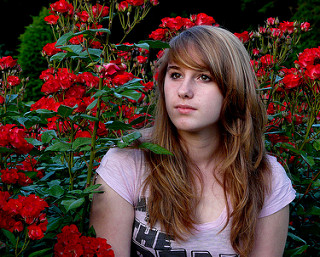

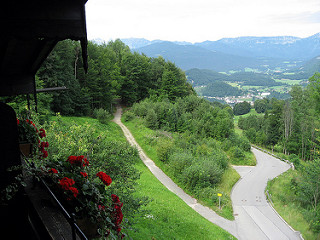

In [ ]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
    display.display(Image.open(str(image_path)))

### Preparando os dados (pré-processar os dados)

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, **datagen_kwargs)
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


### Definindo o modelo (construindo o modelo / montar as camadas)

In [ ]:
do_fine_tuning = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,) + IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


### Treinando o modelo (compilar o modelo / treinar o modelo / avaliar a acurácia)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1), metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

hist = model.fit(train_generator, epochs=5, steps_per_epoch=steps_per_epoch, validation_data=valid_generator, validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - 18s 193ms/step - loss: 0.9295 - accuracy: 0.7454 - val_loss: 0.7396 - val_accuracy: 0.8523
Epoch 2/5
91/91 [==============================] - 17s 185ms/step - loss: 0.6939 - accuracy: 0.8768 - val_loss: 0.6919 - val_accuracy: 0.8722
Epoch 3/5
91/91 [==============================] - 17s 181ms/step - loss: 0.6418 - accuracy: 0.9054 - val_loss: 0.6856 - val_accuracy: 0.8778
Epoch 4/5
91/91 [==============================] - 16s 181ms/step - loss: 0.6242 - accuracy: 0.9137 - val_loss: 0.6962 - val_accuracy: 0.8665
Epoch 5/5
91/91 [==============================] - 16s 175ms/step - loss: 0.6180 - accuracy: 0.9243 - val_loss: 0.6847 - val_accuracy: 0.8750


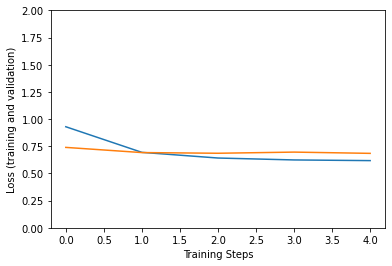

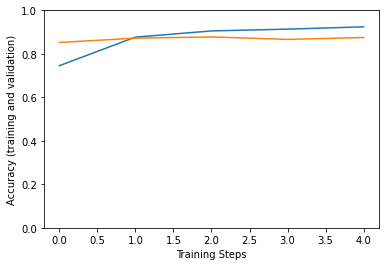

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

### Fazendo previsões com o modelo sobre os dados de validação (fazer predições)

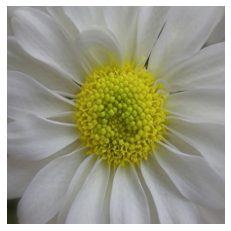

True label: daisy
Predicted label: daisy


In [ ]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

### Salvando o modelo treinado

In [ ]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


## Pergunta 1

Quando o aprendizado da rede neural ocorre?

R: O aprendizado ocorre quando a rede neural atinge uma solução generalizada para uma classe de problemas.

## Pergunta 2

Para grandes volumes de dados (modelos complexos), o desempenho de algoritmos baseados em aprendizado profundo é:

R: Superior às técnicas tradicionais em machine learning.

## Pergunta 3

Neste problema, quantas classes de flores foram identificadas?

In [ ]:
len(CLASS_NAMES)

5

## Pergunta 4

Uma rede neural que poderíamos utilizar no nosso desafio para reconhecer imagens é:

R: Rede Neural Profunda.

## Pergunta 5

Pensando no conceito de Inteligência Artificial, podemos dizer que esse modelo é:

R: Um modelo inteligente que exibe as características as quais nós associamos à inteligência no comportamento humano.

## Pergunta 6

Considere a afirmação “O desempenho do sistema deve melhorar na repetição da mesma tarefa e nas tarefas similares do domínio.” Podemos dizer que ela se aplica ao nosso desafio?

R: Podemos dizer que se aplica ao desafio.

## Pergunta 7

Ao final, para fazer a separação das flores o modelo construído, utilizou-se da técnica de:

R: Classificação.

## Pergunta 8

Qual o tipo de técnica utilizada pelo modelo para classificar as imagens?

R: Clusterização.

## Pergunta 9

Podemos afirmar sobre a camada de convolução de uma rede neural CNN:

R: É a mais importante operação de uma rede CNN.

## Pergunta 10

Para que serve o comando plt.show()?

R: Para plotar algo na tela.

## Pergunta 11

Para que serve o comando model.fit?

R: Treinamento.

## Pergunta 12

Em uma rede neural CNN, podemos afirmar sobre a camada de pooling que:

R: Reduz drasticamente a dimensão espacial da entrada.

## Pergunta 13

Os dados baixados contendo as imagens estão separados em quantos diretórios?

In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
conteudo_flower_photos = list(data_dir.glob('*'))
conteudo_flower_photos

[PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/roses'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/sunflowers'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy')]

In [ ]:
len([path for path in conteudo_flower_photos if os.path.isdir(path)])

5

## Pergunta 14

O conjunto de dados utilizado tem quantas imagens?

In [ ]:
image_count

3670

## Pergunta 15

Podemos considerar que o conjunto de dados utilizados para treinar o modelo foi:

R: Rotulado.

In [ ]:
CLASS_NAMES

array(['dandelion', 'roses', 'tulips', 'sunflowers', 'daisy'],
      dtype='<U10')